In [1]:
import warnings
warnings.filterwarnings("ignore")

## Importing package

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Importing data

In [59]:
adm= pd.read_csv("admissions.csv.gz")
icu= pd.read_csv("icustays.csv.gz")
patients = pd.read_csv('patients.csv.gz')
# d_icd_diag=pd.read_csv('d_icd_diagnoses.csv.gz')

# These data set has not been used because of presence of same feature in other dataset or due to less important feature

diagnosis_icd=pd.read_csv('diagnoses_icd.csv.gz')
proced_icd=pd.read_csv('procedures_icd.csv.gz')
poe=pd.read_csv('poe.csv.gz')
poe_detail=pd.read_csv('poe_detail.csv.gz') 

## Admission data

In [4]:
print(adm.shape)
adm.sample(1)

(431231, 16)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
78964,11861534,20385483,2123-05-14 09:50:00,2123-05-17 11:22:00,NaN,URGENT,P028C3,PHYSICIAN REFERRAL,HOME,Medicaid,ENGLISH,MARRIED,BLACK/CAPE VERDEAN,NaN,NaN,0


In [5]:
print('unique hadm_id',adm['hadm_id'].nunique(), 'and unique subject_id' ,adm['subject_id'].nunique())

unique hadm_id 431231 and unique subject_id 180733


In [6]:
adm.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag'],
      dtype='object')

### Number of previous hospitilization

In [7]:
# Convert 'admittime' to datetime
adm['admittime'] = pd.to_datetime(adm['admittime'])

# Sort DataFrame by subject_id and admittime
adm = adm.sort_values(by=['subject_id', 'admittime'])


# Dictionary to store the last admission time for each subject_id
last_admit_time = {}

# Iterate through each row in the DataFrame to find the last admission time for each subject_id
for index, row in adm.iterrows():
    subject_id = row['subject_id']
    last_admit_time[subject_id] = row['admittime']
    last_admit_time[subject_id]

# Initialize a dictionary to store the hospitalization count for each subject_id
hospitalization_count = {}

# # Iterate through each row in the DataFrame to calculate the previous hospitalization count
for index, row in adm.iterrows():
    subject_id = row['subject_id']
    
    # If subject_id is not in the dictionary, initialize count to 0
    if subject_id not in hospitalization_count:
        hospitalization_count[subject_id] = 0
    
    # If this admission is after the previous discharge time, increment count
    if row['admittime'] > last_admit_time[subject_id]:
        hospitalization_count[subject_id] += 1
    
    # Update the last admission time for the current subject_id
    last_admit_time[subject_id] = row['admittime']
    
    # Update the hospitalization count for the current subject_id
    adm.at[index, 'hospitalization_count'] = hospitalization_count[subject_id]

adm.sample(3)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,hospitalization_count
128591,12990690,23416432,2164-07-29 19:22:00,2164-08-05 15:26:00,NaN,EW EMER.,P73352,PACU,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0,3.0
1945,10046166,23223084,2133-01-10 14:00:00,2133-01-12 13:30:00,NaN,ELECTIVE,P01LRQ,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0,1.0
99925,12340336,27565951,2189-08-10 08:00:00,2189-08-11 11:30:00,NaN,EW EMER.,P54K56,PROCEDURE SITE,HOME,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0,0.0


### Length of stay

In [8]:
# Convert admittime and dischtime to datetime objects if they are not already
adm['admittime'] = pd.to_datetime(adm['admittime'])
adm['dischtime'] = pd.to_datetime(adm['dischtime'])

# Calculate length of stay in days
adm['length_of_stay_days'] = (adm['dischtime'] - adm['admittime']).dt.days

# Display the result
adm.sample(2)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,hospitalization_count,length_of_stay_days
279540,16484054,20657262,2147-07-27 18:26:00,2147-08-02 17:15:00,NaN,URGENT,P48GIG,TRANSFER FROM HOSPITAL,OTHER FACILITY,Other,ENGLISH,WIDOWED,WHITE,NaN,NaN,0,0.0,5
338915,17860364,21134052,2173-10-31 06:42:00,2173-10-31 15:36:00,NaN,EU OBSERVATION,P95N5L,PHYSICIAN REFERRAL,NaN,Other,ENGLISH,MARRIED,WHITE,2173-10-31 04:35:00,2173-10-31 15:36:00,0,0.0,0


In [9]:
adm['admission_type'].value_counts()

EW EMER.                       149413
EU OBSERVATION                  94776
OBSERVATION ADMIT               52668
URGENT                          44691
SURGICAL SAME DAY ADMISSION     34231
DIRECT EMER.                    19554
DIRECT OBSERVATION              18707
ELECTIVE                        10565
AMBULATORY OBSERVATION           6626
Name: admission_type, dtype: int64

#### Recategorize Admission Type

In [10]:
conditions = adm['admission_type'].isin(['EW EMER.', 'URGENT', 'DIRECT EMER.'])
adm['admission_type'] = np.where(conditions, 'Emergency', adm['admission_type'])

conditions = adm['admission_type'].isin(['OBSERVATION ADMIT', 'EU OBSERVATION', 'DIRECT OBSERVATION', 'AMBULATORY OBSERVATION'])
adm['admission_type'] = np.where(conditions, 'Observation', adm['admission_type'])

conditions = adm['admission_type'].isin(['SURGICAL SAME DAY ADMISSION'])
adm['admission_type'] = np.where(conditions, 'Surgical Same Day Admission', adm['admission_type'])

conditions = adm['admission_type'].isin(['ELECTIVE'])
adm['admission_type'] = np.where(conditions, 'Elective', adm['admission_type'])

print(adm.shape)
adm.head(3)

(431231, 18)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,hospitalization_count,length_of_stay_days
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,Emergency,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,0.0,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,Emergency,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,1.0,1
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,Emergency,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,2.0,2


In [11]:
adm['admission_type'].value_counts()

Emergency                      213658
Observation                    172777
Surgical Same Day Admission     34231
Elective                        10565
Name: admission_type, dtype: int64

In [12]:
adm['insurance'].value_counts()

Other       229341
Medicare    160560
Medicaid     41330
Name: insurance, dtype: int64

In [13]:
adm['hospital_expire_flag'].value_counts()

0    422622
1      8609
Name: hospital_expire_flag, dtype: int64

In [14]:
adm['admission_location'].value_counts()

EMERGENCY ROOM                            232595
PHYSICIAN REFERRAL                        114963
TRANSFER FROM HOSPITAL                     35974
WALK-IN/SELF REFERRAL                      15816
CLINIC REFERRAL                            10008
PROCEDURE SITE                              7804
PACU                                        5479
INTERNAL TRANSFER TO OR FROM PSYCH          4205
TRANSFER FROM SKILLED NURSING FACILITY      3843
INFORMATION NOT AVAILABLE                    359
AMBULATORY SURGERY TRANSFER                  185
Name: admission_location, dtype: int64

#### Recategorize Admission Location

In [15]:
conditions = adm['admission_location'].isin(['WALK-IN/SELF REFERRAL',"CLINIC REFERRAL","PROCEDURE SITE","PACU","INTERNAL TRANSFER TO OR FROM PSYCH",
                      "TRANSFER FROM SKILLED NURSING FACILITY","INFORMATION NOT AVAILABLE",
                      "AMBULATORY SURGERY TRANSFER"])
adm['admission_location'] = np.where(conditions, 'other', adm['admission_location'])

In [16]:
adm['admission_location'].value_counts()

EMERGENCY ROOM            232595
PHYSICIAN REFERRAL        114963
other                      47699
TRANSFER FROM HOSPITAL     35974
Name: admission_location, dtype: int64

In [17]:
adm['race'].value_counts()

WHITE                                        272932
BLACK/AFRICAN AMERICAN                        59959
OTHER                                         15102
UNKNOWN                                       10668
HISPANIC/LATINO - PUERTO RICAN                 8076
WHITE - OTHER EUROPEAN                         7925
HISPANIC OR LATINO                             7754
ASIAN                                          6156
ASIAN - CHINESE                                5587
WHITE - RUSSIAN                                5024
BLACK/CAPE VERDEAN                             4765
HISPANIC/LATINO - DOMINICAN                    4383
BLACK/CARIBBEAN ISLAND                         2704
BLACK/AFRICAN                                  2530
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
ASIAN - SOUTH EAST ASIAN                       1446
HISPANIC/LATINO - GUATEMALAN                   1330
ASIAN - ASIA

### Recategorize Race

In [18]:

adm['race'] = np.where(adm['race'].isin(['AMERICAN INDIAN/ALASKA NATIVE']), 'AMERICAN INDIAN/ALASKA NATIVE',
                            np.where(adm['race'].isin(['ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CHINESE',
                                                                           'ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN']),
                                     'ASIAN',
                            np.where(adm['race'].isin(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 
                                                                           'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']),
                                     'BLACK/AFRICAN',
                            np.where(adm['race'].isin(['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN',
                                                                           'HISPANIC/LATINO - COLUMBIAN', 'HISPANIC/LATINO - CUBAN',
                                                                           'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 
                                                                           'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 
                                                                           'HISPANIC/LATINO - PUERTO RICAN','HISPANIC/LATINO - SALVADORAN']), 
                                     'HISPANIC OR LATINO',
                            np.where(adm['race'].isin(['NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']), 
                                     'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                            np.where(adm['race'].isin(['MULTIPLE RACE/race', 'OTHER', 
                                                                      'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN', 'UNKNOWN']), 
                                     'OTHER',
                            np.where(adm['race'].isin(['PORTUGUESE']), 'PORTUGUESE',
                            np.where(adm['race'].isin(['SOUTH AMERICAN']), 'SOUTH AMERICAN',
                            np.where(adm['race'].isin(['WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN',
                                                                           'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN']), 
                                     'WHITE',
                    np.nan)))))))))

round(adm.race.value_counts(normalize=True)*100)

WHITE                                        67.0
BLACK/AFRICAN                                16.0
OTHER                                         7.0
HISPANIC OR LATINO                            6.0
ASIAN                                         3.0
PORTUGUESE                                    0.0
AMERICAN INDIAN/ALASKA NATIVE                 0.0
nan                                           0.0
SOUTH AMERICAN                                0.0
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER     0.0
Name: race, dtype: float64

In [19]:
adm['race'].value_counts()

WHITE                                        288154
BLACK/AFRICAN                                 69958
OTHER                                         29134
HISPANIC OR LATINO                            25212
ASIAN                                         14893
PORTUGUESE                                     1510
AMERICAN INDIAN/ALASKA NATIVE                   919
nan                                             560
SOUTH AMERICAN                                  505
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       386
Name: race, dtype: int64

In [20]:
adm.sample(1)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,hospitalization_count,length_of_stay_days
287122,16662316,29953834,2171-06-23 07:41:00,2171-06-23 16:42:00,NaN,Observation,P476C6,EMERGENCY ROOM,NaN,Medicare,ENGLISH,DIVORCED,WHITE,2171-06-23 01:05:00,2171-06-23 16:42:00,0,2.0,0


In [21]:
# col_drop=[ 'admittime', 'dischtime', 'deathtime','admit_provider_id', 'discharge_location','language', 'marital_status',
#        'edregtime', 'edouttime','hospital_expire_flag']
# adm.drop(col_drop, axis=1, inplace= True)

In [22]:
print('unique hadm_id',adm['hadm_id'].nunique(), 'and unique subject_id' ,adm['subject_id'].nunique())
print("Final admission data")
#print(adm['hadm_id'].nunique())
adm.head(3)

unique hadm_id 431231 and unique subject_id 180733
Final admission data


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,hospitalization_count,length_of_stay_days
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,Emergency,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,0.0,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,Emergency,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,1.0,1
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,Emergency,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,2.0,2


### Patient data

In [23]:
patients.sample(1)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
92793,13106312,M,79,2185,2011 - 2013,2190-11-03


In [24]:
# merging the patient and admission data
adm_pat=pd.merge(adm,patients,on='subject_id',how='left')
print('shape of adm_pat', adm_pat.shape,'and shape of adm', adm.shape)
adm_pat.sample(1)

shape of adm_pat (431231, 23) and shape of adm (431231, 18)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,edregtime,edouttime,hospital_expire_flag,hospitalization_count,length_of_stay_days,gender,anchor_age,anchor_year,anchor_year_group,dod
165406,13860914,27960740,2183-06-28 14:06:00,2183-06-29 18:13:00,NaN,Emergency,P534S8,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,2183-06-28 10:20:00,2183-06-28 15:20:00,0,2.0,1,F,78,2182,2008 - 2010,NaN


In [25]:
adm_pat.columns
# patients.drop(columns=['dod','anchor_year','anchor_year_group'], inplace=True)

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag',
       'hospitalization_count', 'length_of_stay_days', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod'],
      dtype='object')

#### Diagnosis Code(ICD)

In [26]:
diagnosis_icd.sample(3)
print(diagnosis_icd.shape)

(4756326, 5)


In [27]:
diagnosis_icd['icd'] = diagnosis_icd.icd_code.str[:3]
diagnosis_icd.sample(4)

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd
1284001,12698967,20376654,13,R609,10,R60
3593859,17549969,21091045,9,27800,9,278
4382347,19210570,23695811,1,I160,10,I16
2238299,14697503,28430517,5,29420,9,294


### ICD Code

- 001–139: infectious and parasitic diseases
- 140–239: neoplasms
- 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
- 280–289: diseases of the blood and blood-forming organs
- 290–319: mental disorders
- 320–389: diseases of the nervous system and sense organs
- 390–459: diseases of the circulatory system
- 460–519: diseases of the respiratory system
- 520–579: diseases of the digestive system
- 580–629: diseases of the genitourinary system
- 630–679: complications of pregnancy, childbirth, and the puerperium
- 680–709: diseases of the skin and subcutaneous tissue
- 710–739: diseases of the musculoskeletal system and connective tissue
- 740–759: congenital anomalies
- 760–779: certain conditions originating in the perinatal period
- 780–799: symptoms, signs, and ill-defined conditions
- 800–999: injury and poisoning
- E and V codes: external causes of injury and supplemental classification


***Chapter	Block	Title***
- https://www.icd10data.com/ICD10CM/Codes
- I	A00–B99	Certain infectious and parasitic diseases
- II	C00–D48	Neoplasms
- III	D50–D89	Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism
- IV	E00–E90	Endocrine, nutritional and metabolic diseases
- V	F00–F99	Mental and behavioural disorders
- VI	G00–G99	Diseases of the nervous system
- VII	H00–H59	Diseases of the eye and adnexa
- VIII	H60–H95	Diseases of the ear and mastoid process
- IX	I00–I99	Diseases of the circulatory system
- X	J00–J99	Diseases of the respiratory system
- XI	K00–K93	Diseases of the digestive system
- XII	L00–L99	Diseases of the skin and subcutaneous tissue
- XIII	M00–M99	Diseases of the musculoskeletal system and connective tissue
- XIV	N00–N99	Diseases of the genitourinary system
- XV	O00–O99	Pregnancy, childbirth and the puerperium
- XVI	P00–P96	Certain conditions originating in the perinatal period
- XVII	Q00–Q99	Congenital malformations, deformations and chromosomal abnormalities
- XVIII	R00–R99	Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified
- XIX	S00–T98	Injury, poisoning and certain other consequences of external causes
- XX	V01–Y98	External causes of morbidity and mortality
- XXI	Z00–Z99	Factors influencing health status and contact with health services
- XXII	U00–U99	Codes for special purposes

### Map icd code

In [28]:
# Function to categorize ICD codes
def categorize_icd(icd):
    try:
        if 1 <= int(icd) <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= int(icd) <= 239:
            return 'Neoplasms'
        elif 240 <= int(icd) <= 279:
            return 'Endocrine, Nutritional, and Metabolic Diseases'
        elif 280 <= int(icd) <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= int(icd) <= 319:
            return 'Mental Disorders'
        elif 320 <= int(icd) <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= int(icd) <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= int(icd) <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= int(icd) <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= int(icd) <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= int(icd) <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= int(icd) <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= int(icd) <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= int(icd) <= 759:
            return 'Congenital Anomalies'
        elif 760 <= int(icd) <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= int(icd) <= 799:
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif 800 <= int(icd) <= 999:
            return 'Injury and Poisoning'
        
    except ValueError:
        if icd[0] == 'A' or icd[0] == 'B':
            return 'Infectious and Parasitic Diseases'
        elif icd[0] == 'C':
            return 'Neoplasms'
        elif icd[0] == 'D':
            return 'Diseases of the Blood and Blood-forming Organs'
        elif icd[0] == 'E':
            return 'External causes of injury and supplemental classification'
        elif icd[0] == 'F':
            return 'Mental Disorders'
        elif icd[0] == 'G':
            return 'Diseases of the Nervous System and Sense Organs'
        elif icd[0] == 'H':
            return 'Diseases of the eye, adnexa and mastoid process'
        elif icd[0] == 'I':
            return 'Diseases of the Circulatory System'
        elif icd[0] == 'J':
            return 'Diseases of the Respiratory System'
        elif icd[0] == 'K':
            return 'Diseases of the Digestive System'
        elif icd[0] == 'L':
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif icd[0] == 'M':
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif icd[0] == 'N':
            return 'Diseases of the Genitourinary System'
        elif icd[0] == 'O':
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif icd[0] == 'P':
            return 'Certain Conditions Originating in the Perinatal Period'
        elif icd[0] == 'Q':
            return 'Congenital Anomalies'
        elif icd[0] == 'R':
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif icd[0] == 'S' or icd[0] == 'T' :
            return 'Injury and Poisoning'
        elif icd[0] == 'U':
            return 'Codes for special purposes'
        elif icd[0] in ['V', 'W', 'X' ,'Y']:
            return 'External causes of injury and supplemental classification'
        elif icd[0] == 'Z':
            return 'Factors influencing health status and contact with health services'
                
        
# Apply function to create a new column
diagnosis_icd['diagnosis'] = diagnosis_icd['icd'].apply(categorize_icd)
diagnosis_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd,diagnosis
0,10000032,22595853,1,5723,9,572,Diseases of the Digestive System
1,10000032,22595853,2,78959,9,789,"Symptoms, Signs, and Ill-defined Conditions"
2,10000032,22595853,3,5715,9,571,Diseases of the Digestive System
3,10000032,22595853,4,07070,9,070,Infectious and Parasitic Diseases
4,10000032,22595853,5,496,9,496,Diseases of the Respiratory System


#### Analysis on diagnosis_icd

######  Grouping the data by 'subject_id' and counting unique 'hadm_id' 
Here we found that we have multiple hadm_id to particular subject id

In [29]:
hadm_counts = diagnosis_icd.groupby('subject_id')['hadm_id'].count()
# Displaying the counts of 'hadm_id' for each 'subject_id'
hadm_counts

subject_id
10000032     39
10000068      1
10000084     12
10000108      2
10000117     22
           ... 
19999733      3
19999784    154
19999828     41
19999840     19
19999987     11
Name: hadm_id, Length: 180640, dtype: int64

#### Droping useless attribute

In [30]:
diagnosis_icd.drop(columns=['icd_version','seq_num','icd','icd_code'], inplace=True)

In [31]:
print("duplicate in combination of 'subject_id','hadm_id', 'diagnosis'", diagnosis_icd.duplicated().sum())
diagnosis_icd.head(3)

duplicate in combination of 'subject_id','hadm_id', 'diagnosis' 2301198


,subject_id,hadm_id,diagnosis
0,10000032,22595853,Diseases of the Digestive System
1,10000032,22595853,"Symptoms, Signs, and Ill-defined Conditions"
2,10000032,22595853,Diseases of the Digestive System


#### Creating pivot table to map each hadm_id and subject_id with their diagnosis

In [32]:
pivoted_df = pd.pivot_table(diagnosis_icd, index=['subject_id', 'hadm_id'], columns='diagnosis', aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0)

# Reset index to make subject_id and hadm_id as columns
pivoted_df.reset_index(inplace=True)

pivoted_df.sample(5)


diagnosis,subject_id,hadm_id,Certain Conditions Originating in the Perinatal Period,"Complications of Pregnancy, Childbirth, and the Puerperium",Congenital Anomalies,Diseases of the Blood and Blood-forming Organs,Diseases of the Circulatory System,Diseases of the Digestive System,Diseases of the Genitourinary System,Diseases of the Musculoskeletal System and Connective Tissue,...,Diseases of the Skin and Subcutaneous Tissue,"Diseases of the eye, adnexa and mastoid process","Endocrine, Nutritional, and Metabolic Diseases",External causes of injury and supplemental classification,Factors influencing health status and contact with health services,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions"
377807,18756184,22677548,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
177368,14131015,25451869,0,0,0,0,1,0,0,1,...,0,0,0,1,1,1,0,1,0,0
324465,17525617,20949595,0,0,0,0,1,1,0,1,...,0,0,0,1,1,0,0,1,0,1
315449,17320281,21644981,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,1
313252,17270380,20152762,0,0,1,1,1,0,1,1,...,0,0,1,1,0,1,1,0,0,1


### Merging the admission, patient, diagosis data

In [33]:
adm_pat_diag=pd.merge(adm_pat,pivoted_df,on=['subject_id','hadm_id'],how='inner')

In [34]:
print(adm_pat_diag.shape)
adm_pat_diag.sample(2)

(430852, 43)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,Diseases of the Skin and Subcutaneous Tissue,"Diseases of the eye, adnexa and mastoid process","Endocrine, Nutritional, and Metabolic Diseases",External causes of injury and supplemental classification,Factors influencing health status and contact with health services,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions"
166444,13884619,26792689,2115-09-26 13:10:00,2115-10-07 19:46:00,NaN,Elective,P41R5N,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,...,0,0,0,1,1,1,0,1,0,1
335133,17778672,23552390,2189-03-18 15:31:00,2189-03-19 15:31:00,NaN,Observation,P6683B,EMERGENCY ROOM,NaN,Other,...,0,0,0,0,0,0,0,1,0,1


#### OMR

In [35]:
omr=pd.read_csv('omr.csv.gz')
omr.sample(5)

,subject_id,chartdate,seq_num,result_name,result_value
1643769,12581872,2164-10-09,1,Weight (Lbs),135.5
3432430,15352872,2181-04-23,1,BMI (kg/m2),25.9
5207114,18092862,2168-05-17,1,Weight (Lbs),251
6401915,19942382,2199-08-04,1,Blood Pressure,134/98
5127667,17966332,2133-01-30,1,BMI (kg/m2),39.5


In [36]:
omr['result_name'].value_counts()

Blood Pressure                      2169549
Weight (Lbs)                        1889542
BMI (kg/m2)                         1662112
Height (Inches)                      706906
Blood Pressure Sitting                 3400
Blood Pressure Lying                   2764
Blood Pressure Standing (1 min)        2560
Blood Pressure Standing (3 mins)        626
BMI                                     554
Blood Pressure Standing                 523
Weight                                  354
eGFR                                    240
Height                                   39
Name: result_name, dtype: int64

In [37]:
# Pivot the DataFrame
pivot_omr = omr.pivot_table(index='subject_id', columns='result_name', values='result_value', aggfunc='first')

# Reset the index to make 'subject_id' a column again
pivot_omr.reset_index(inplace=True)

# Display the pivoted DataFrame
pivot_omr


result_name,subject_id,BMI,BMI (kg/m2),Blood Pressure,Blood Pressure Lying,Blood Pressure Sitting,Blood Pressure Standing,Blood Pressure Standing (1 min),Blood Pressure Standing (3 mins),Height,Height (Inches),Weight,Weight (Lbs),eGFR
0,10000032,NaN,18.0,110/65,NaN,NaN,NaN,NaN,NaN,NaN,60,NaN,94,NaN
1,10000084,NaN,24.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,NaN,170,NaN
2,10000117,NaN,19.6,124/66,NaN,NaN,NaN,NaN,NaN,NaN,64.5,NaN,121,NaN
3,10000248,NaN,25.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68,NaN,168.00,NaN
4,10000280,NaN,NaN,124/62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158311,19999636,NaN,NaN,118/58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128,NaN
158312,19999733,NaN,NaN,108/70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154,NaN
158313,19999750,NaN,27.7,153/93,NaN,NaN,NaN,NaN,NaN,NaN,68,NaN,182,NaN
158314,19999784,NaN,23.8,129/87,NaN,NaN,NaN,NaN,NaN,NaN,67,NaN,152,NaN


In [38]:
print("Null value count")
print('-'*50)
for column in pivot_omr.columns:
    null_count = pivot_omr[column].isnull().sum()
    print(f"{column}: {null_count}")

Null value count
--------------------------------------------------
subject_id: 0
BMI: 157844
BMI (kg/m2): 20680
Blood Pressure: 22722
Blood Pressure Lying: 156687
Blood Pressure Sitting: 156339
Blood Pressure Standing: 157947
Blood Pressure Standing (1 min): 156709
Blood Pressure Standing (3 mins): 157874
Height: 158278
Height (Inches): 25372
Weight: 158011
Weight (Lbs): 8439
eGFR: 158132


In [39]:
## droping columns which have high number of null value
columns_to_keep = ['subject_id','BMI (kg/m2)', 'Blood Pressure', 'Weight (Lbs)']

# Filter the DataFrame to keep only the specified columns
omr = pivot_omr.loc[:, pivot_omr.columns.isin(columns_to_keep)]

omr.sample(3)

result_name,subject_id,BMI (kg/m2),Blood Pressure,Weight (Lbs)
153184,19675312,20.1,120/81,140
141384,18938189,20.9,NaN,150
24632,11570307,25.0,187/74,132.5


In [40]:
# Split 'Blood Pressure' into 'Systolic Pressure' and 'Diastolic Pressure'
omr[['Systolic Pressure', 'Diastolic Pressure']] = omr['Blood Pressure'].str.split('/', expand=True)

# Drop the original 'Blood Pressure' column
omr.drop('Blood Pressure', axis=1, inplace=True)
print(omr)

result_name  subject_id BMI (kg/m2) Weight (Lbs) Systolic Pressure  \
0              10000032        18.0           94               110   
1              10000084        24.4          170               NaN   
2              10000117        19.6          121               124   
3              10000248        25.5       168.00               NaN   
4              10000280         NaN          174               124   
...                 ...         ...          ...               ...   
158311         19999636         NaN          128               118   
158312         19999733         NaN          154               108   
158313         19999750        27.7          182               153   
158314         19999784        23.8          152               129   
158315         19999828        25.7          150               130   

result_name Diastolic Pressure  
0                           65  
1                          NaN  
2                           66  
3                          

In [41]:
omr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158316 entries, 0 to 158315
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   subject_id          158316 non-null  int64 
 1   BMI (kg/m2)         137636 non-null  object
 2   Weight (Lbs)        149877 non-null  object
 3   Systolic Pressure   135594 non-null  object
 4   Diastolic Pressure  135594 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [42]:
omr.isnull().sum()

result_name
subject_id                0
BMI (kg/m2)           20680
Weight (Lbs)           8439
Systolic Pressure     22722
Diastolic Pressure    22722
dtype: int64

In [43]:
omr['BMI (kg/m2)']=pd.to_numeric(omr['BMI (kg/m2)'],errors='coerce')
omr['Weight (Lbs)']=pd.to_numeric(omr['Weight (Lbs)'],errors='coerce')
omr['Systolic Pressure']=pd.to_numeric(omr['Systolic Pressure'],errors='coerce')
omr['Diastolic Pressure']=pd.to_numeric(omr['Diastolic Pressure'],errors='coerce')
omr.dropna()

result_name,subject_id,BMI (kg/m2),Weight (Lbs),Systolic Pressure,Diastolic Pressure
0,10000032,18.0,94.0,110.0,65.0
2,10000117,19.6,121.0,124.0,66.0
6,10000635,31.7,221.0,140.0,86.0
7,10000719,37.0,236.0,144.0,88.0
9,10000826,20.5,98.9,88.0,58.0
...,...,...,...,...,...
158308,19999442,26.3,213.0,122.0,82.0
158309,19999464,27.6,124.5,118.0,62.0
158313,19999750,27.7,182.0,153.0,93.0
158314,19999784,23.8,152.0,129.0,87.0


In [44]:
omr.columns

Index(['subject_id', 'BMI (kg/m2)', 'Weight (Lbs)', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object', name='result_name')

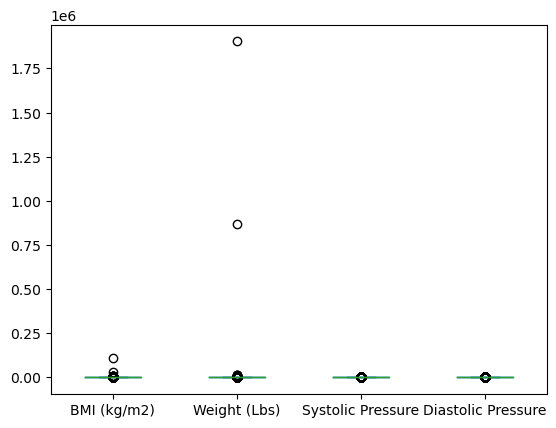

In [45]:
omr[['BMI (kg/m2)', 'Weight (Lbs)', 'Systolic Pressure', 'Diastolic Pressure']].plot(kind='box');

#### Removing Outlier from ['BMI (kg/m2)', 'Weight (Lbs)', 'Systolic Pressure', 'Diastolic Pressure']

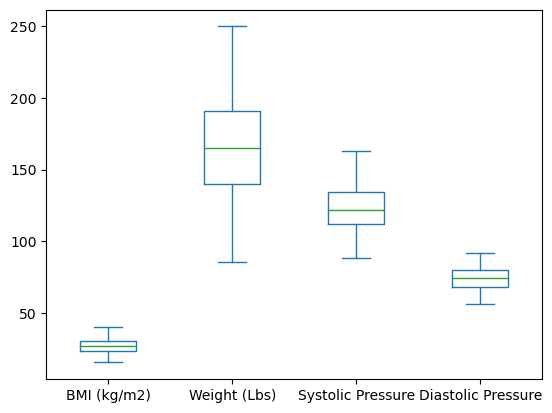

In [46]:
columns_to_process = ['BMI (kg/m2)', 'Weight (Lbs)', 'Systolic Pressure', 'Diastolic Pressure']

for column in columns_to_process:
    # Calculate the IQR
    Q1 = omr[column].quantile(0.25)
    Q3 = omr[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the threshold for outliers
    threshold = 1
    
    # Define the range for non-outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Filter out outliers
    omr = omr[(omr[column] >= lower_bound) & (omr[column] <= upper_bound)]

# Plot the box plots for the cleaned data
omr[columns_to_process].plot(kind='box');



In [47]:
omr.shape

(92565, 5)

In [48]:
adm_pat_diag['subject_id'].nunique()

180640

In [49]:
adm_pat_diag_omr=pd.merge(adm_pat_diag,omr,how='inner',on='subject_id')
adm_pat_diag_omr

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,Factors influencing health status and contact with health services,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions",BMI (kg/m2),Weight (Lbs),Systolic Pressure,Diastolic Pressure
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,Emergency,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,0,1,0,1,0,1,18.0,94.0,110.0,65.0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,Emergency,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,0,1,0,1,0,1,18.0,94.0,110.0,65.0
2,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,Emergency,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,0,1,0,1,0,1,18.0,94.0,110.0,65.0
3,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,Emergency,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,0,1,0,1,0,1,18.0,94.0,110.0,65.0
4,10000117,22927623,2181-11-15 02:05:00,2181-11-15 14:52:00,NaN,Observation,P2358X,EMERGENCY ROOM,NaN,Other,...,1,0,0,1,0,1,19.6,121.0,124.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214455,19999784,29889147,2120-10-25 09:43:00,2120-10-31 09:00:00,NaN,Elective,P86PTJ,PHYSICIAN REFERRAL,HOME,Medicaid,...,1,1,0,1,1,1,23.8,152.0,129.0,87.0
214456,19999784,29956342,2121-01-31 00:00:00,2121-02-05 12:44:00,NaN,Elective,P86PTJ,PHYSICIAN REFERRAL,HOME,Medicaid,...,1,0,0,0,1,0,23.8,152.0,129.0,87.0
214457,19999784,24755486,2121-05-30 09:22:00,2121-06-05 08:48:00,NaN,Elective,P86PTJ,PHYSICIAN REFERRAL,HOME,Medicaid,...,1,0,0,1,1,0,23.8,152.0,129.0,87.0
214458,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,Emergency,P16C7J,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,...,1,1,1,1,0,0,25.7,150.0,130.0,88.0


### Prescription

In [50]:
Pres=pd.read_csv("prescriptions.csv.gz")
Pres.sample(3)

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,...,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
14360676,19319186,22915000,52129078,19319186-1241,1241.0,P43TXZ,2159-12-11 06:00:00,2159-12-11 16:00:00,MAIN,Heparin,...,006549,6.410400e+08,5000 Units / mL- 1mL Vial,NaN,5000,UNIT,1,mL,1.0,SC
7461985,14831807,22089864,76320889,14831807-302,302.0,P748G6,2153-08-03 03:00:00,2153-08-17 22:00:00,MAIN,Magnesium Sulfate,...,063347,4.096729e+08,4 g / 100 mL Premix Bag,NaN,4,gm,1,BAG,NaN,IV
12287224,17969407,22399429,44182963,17969407-156,156.0,P021VX,2172-04-14 10:00:00,2172-04-18 19:00:00,MAIN,Polyethylene Glycol,...,041843,5.199105e+10,17g Packet,NaN,17,g,1,PKT,NaN,PO/NG


In [51]:
Pres['hadm_id'].nunique()

365442

In [52]:
Pres.columns

Index(['subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'poe_seq',
       'order_provider_id', 'starttime', 'stoptime', 'drug_type', 'drug',
       'formulary_drug_cd', 'gsn', 'ndc', 'prod_strength', 'form_rx',
       'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp',
       'doses_per_24_hrs', 'route'],
      dtype='object')

In [53]:
col_to_drop=['pharmacy_id', 'poe_id', 'poe_seq',
       'order_provider_id', 'starttime', 'stoptime', 'drug',
       'formulary_drug_cd', 'gsn', 'ndc', 'prod_strength', 'form_rx',
       'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp',
       'doses_per_24_hrs', 'route']
Pres.drop(columns=col_to_drop,inplace=True)

In [54]:
print(Pres.shape)
group=Pres.groupby(['subject_id','hadm_id']).count()
group
# Pres.sample(3)


(15416708, 3)


drug_type
subject_id hadm_id            
10000032   22595853         14
           22841357         15
           25742920         28
           29079034         24
10000084   23052089         13
...                        ...
19999828   25744818        141
           29734428         68
19999840   21033226        120
           26071774         17
19999987   23865745         80

[365442 rows x 1 columns]

In [55]:
Pres['drug_type'].value_counts()

MAIN        12749884
BASE         2642933
ADDITIVE       23891
Name: drug_type, dtype: int64

In [56]:
print(Pres['subject_id'].nunique())
Pres.drop_duplicates()

158421


,subject_id,hadm_id,drug_type
0,10000032,22595853,MAIN
14,10000032,22841357,MAIN
29,10000032,25742920,MAIN
39,10000032,25742920,BASE
57,10000032,29079034,MAIN
...,...,...,...
15416494,19999840,21033226,BASE
15416611,19999840,26071774,MAIN
15416618,19999840,26071774,BASE
15416628,19999987,23865745,BASE


### Poe/ Poe_detail

In [60]:
poe_detail.sample(5)


,poe_id,poe_seq,subject_id,field_name,field_value
3205303,18258503-1065,1065,18258503,Discharge Planning,Finalized
2161598,15572473-139,139,15572473,Tubes & Drains type,Straight cath
2314379,15964158-430,430,15964158,Transfer to,Surgery
1556722,14018165-14,14,14018165,Admit to,Cardiology NP
3220759,18295168-130,130,18295168,Admit category,Admit to inpatient


In [61]:
poe_detail['field_name'].value_counts()

Admit category         1093726
Admit to                881522
Tubes & Drains type     491472
Discharge Planning      475428
Discharge When          431642
Code status             197932
Transfer to             161707
Level of Urgency         45617
Consult Status           36591
Consult Status Time      36591
Indication               27190
Name: field_name, dtype: int64

In [62]:
poe_detail['field_value'].value_counts()

Admit to inpatient                           774899
Medicine                                     589881
Finalized                                    475428
Discharge Now                                431642
Indwelling urinary catheter (IUC) - Foley    384055
                                              ...  
2110-09-26 08:47:53                               1
2178-04-13 13:13:44                               1
2165-06-29 10:04:31                               1
2165-07-07 13:27:07                               1
2149-01-09 09:07:00                               1
Name: field_value, Length: 36656, dtype: int64

In [63]:
poe.sample(3)

,poe_id,poe_seq,subject_id,hadm_id,ordertime,order_type,order_subtype,transaction_type,discontinue_of_poe_id,discontinued_by_poe_id,order_provider_id,order_status
18853123,14784406-19,19,14784406,29067422,2125-06-04 22:04:56,IV therapy,IV fluids,New,NaN,14784406-41,P70MVB,Inactive
22359257,15665196-184,184,15665196,27099210,2152-05-22 14:03:29,General Care,Other,New,NaN,15665196-240,P869HV,Inactive
19387861,14923011-1440,1440,14923011,28731392,2158-11-13 23:45:29,Medications,NaN,New,NaN,NaN,P458GD,Inactive


In [64]:
poe['order_type'].value_counts()

Medications      17690066
Lab               6565578
General Care      5690221
ADT orders        2171456
IV therapy        2140236
Nutrition         1640521
Radiology         1423870
Consults           582086
Blood Bank         500819
Respiratory        459126
Cardiology         294187
TPN                 67089
Critical Care       48771
Hemodialysis        37370
Neurology           28857
OB                  26038
Name: order_type, dtype: int64

In [65]:
poe['order_subtype'].value_counts()

Other                            1701334
IV fluids                        1206817
Diet Order                       1185352
Discharge                        1106327
Vitals/Monitoring                 961199
                                  ...   
Urine                                  3
Pain Medication/Bowel Regimen          2
Blood Gases/Whole Blood                2
Flushes                                1
Drug Monitoring                        1
Name: order_subtype, Length: 133, dtype: int64

### Emar

In [66]:
emar=pd.read_csv("emar.csv.gz")

In [67]:
emar.sample(3)

,subject_id,hadm_id,emar_id,emar_seq,poe_id,pharmacy_id,enter_provider_id,charttime,medication,event_txt,scheduletime,storetime
5375509,12022798,28842792.0,12022798-61,61,12022798-54,764933.0,NaN,2151-11-14 05:46:00,Acetaminophen,Administered,2151-11-14 06:00:00,2151-11-14 05:46:00
13682876,15107347,21277573.0,15107347-2024,2024,15107347-5091,58117134.0,NaN,2161-09-04 08:31:00,Mupirocin Ointment 2%,Administered,2161-09-04 08:00:00,2161-09-04 08:36:00
26520344,19871412,21492054.0,19871412-55,55,19871412-41,65177282.0,NaN,2148-12-24 11:00:00,Fleet Enema,Administered,2148-12-24 13:26:00,2148-12-24 13:27:00


In [68]:
emar['medication'].value_counts()

Sodium Chloride 0.9%  Flush       2895223
Insulin                           1585016
Heparin                           1277148
Acetaminophen                     1051858
Docusate Sodium                    741392
                                   ...   
Prenatal-1                              1
semaglutide                             1
phenylephrine HCl in 0.9% NaCl          1
GaviLyte-G                              1
Niacinamide/Placebo                     1
Name: medication, Length: 4186, dtype: int64

In [69]:
emar['event_txt'].value_counts()

Administered                                     17809021
Flushed                                           2132413
Not Given                                         1858880
Confirmed                                         1168574
Not Flushed                                        901190
                                                   ...   
Not Given per Sliding Scale in Other Location           3
Delayed Not Stopped                                     1
Delayed Stopped As Directed                             1
Delayed Not Assessed                                    1
Infusion Reconciliation in Other Location               1
Name: event_txt, Length: 70, dtype: int64

### Labevents

In [70]:
lab_event=pd.read_csv('labevents.csv.gz',nrows=100000)
lab_event.sample(3)

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
88042,88184,10006431,NaN,45361697,51482,P52TGZ,2128-11-25 12:20:00,2128-11-25 13:34:00,2,2.0,#/lpf,0.0,0.0,abnormal,STAT,NaN
29488,29520,10002430,NaN,78680307,51287,P126ZX,2126-05-19 14:00:00,2126-05-19 15:49:00,NaN,NaN,NaN,NaN,NaN,NaN,STAT,OCCASIONAL.
84031,84166,10006029,NaN,11257778,51244,P46NNJ,2170-01-30 08:44:00,2170-01-30 08:48:00,21.1,21.1,%,19.0,53.0,NaN,STAT,NaN


In [71]:
lab_event['priority'].value_counts()

STAT       49822
ROUTINE    45744
Name: priority, dtype: int64

In [72]:
lab_event['flag'].value_counts()

abnormal    29212
Name: flag, dtype: int64

In [73]:
lab_event['itemid'].value_counts()

50912    2819
51221    2795
51006    2731
51265    2679
51222    2676
         ... 
51044       1
51235       1
51291       1
50844       1
51091       1
Name: itemid, Length: 484, dtype: int64

### microbiological event

In [74]:
micro=pd.read_csv('microbiologyevents.csv.gz',nrows=100000)
lab_event.sample(3)

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
4671,4679,10000935,NaN,73639782,51248,NaN,2186-05-27 09:00:00,2186-05-27 09:38:00,29.5,29.5,pg,27.0,32.0,NaN,STAT,NaN
98890,99046,10007920,NaN,92966742,50988,P46U9R,2137-12-11 11:50:00,2137-12-11 18:44:00,562,562.0,ng/dL,280.0,800.0,NaN,ROUTINE,NaN
71727,71840,10005271,NaN,43136653,51482,NaN,2167-11-19 16:12:00,2167-11-19 16:39:00,5,5.0,#/lpf,0.0,0.0,abnormal,STAT,NaN


### ICU Data

This data is only taken to generate target class

In [75]:
icu.sample(5)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
29941,14071926,27301047,31668670,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2126-12-17 11:16:20,2126-12-19 12:26:45,2.048900
24735,13369675,29977761,32748319,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2187-01-31 19:24:17,2187-02-04 15:42:19,3.845856
57994,17937834,21087265,31535797,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2141-11-29 11:41:40,2141-11-29 15:49:35,0.172164
9747,11318805,24281008,37306088,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2170-03-24 13:56:38,2170-03-27 19:52:23,3.247049
20603,12803765,27494717,35130661,Trauma SICU (TSICU),Trauma SICU (TSICU),2129-01-15 02:36:16,2129-01-18 14:51:44,3.510741


In [76]:
icu['hadm_id'].nunique()

66239

In [77]:
icu_hadm_ids = set(icu['hadm_id'])

# Create 'icu_admit' column in adm_pat_diag_omr dataframe
adm_pat_diag_omr['icu_admit'] = adm_pat_diag_omr['hadm_id'].apply(lambda x: 1 if x in icu_hadm_ids else 0)
adm_pat_diag_omr.sample(3)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions",BMI (kg/m2),Weight (Lbs),Systolic Pressure,Diastolic Pressure,icu_admit
128444,15980320,22615512,2161-02-07 16:14:00,2161-02-08 18:00:00,NaN,Observation,P00P3O,EMERGENCY ROOM,HOME,Medicaid,...,0,1,1,0,0,19.0,140.0,117.0,80.0,0
164551,17654652,21901630,2145-11-10 09:45:00,2145-11-11 14:20:00,NaN,Emergency,P76K54,PHYSICIAN REFERRAL,HOME,Other,...,0,0,0,0,0,34.3,239.2,124.0,62.0,0
60650,12850463,20853486,2196-06-17 13:45:00,2196-06-18 10:30:00,NaN,Observation,P75JMU,PHYSICIAN REFERRAL,NaN,Other,...,0,0,0,0,0,31.6,196.0,129.0,70.0,0


In [78]:
adm_pat_diag_omr.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag',
       'hospitalization_count', 'length_of_stay_days', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod',
       'Certain Conditions Originating in the Perinatal Period',
       'Complications of Pregnancy, Childbirth, and the Puerperium',
       'Congenital Anomalies',
       'Diseases of the Blood and Blood-forming Organs',
       'Diseases of the Circulatory System',
       'Diseases of the Digestive System',
       'Diseases of the Genitourinary System',
       'Diseases of the Musculoskeletal System and Connective Tissue',
       'Diseases of the Nervous System and Sense Organs',
       'Diseases of the Respiratory System',
       'Diseases of the Skin and Subcutaneous Tissue',
       'D

#### Scaling the col

In [79]:
from sklearn.preprocessing import MinMaxScaler

col_to_scale= [ 'length_of_stay_days','BMI (kg/m2)','Weight (Lbs)', 'Systolic Pressure', 'Diastolic Pressure']

scaler = MinMaxScaler()
adm_pat_diag_omr[col_to_scale] = scaler.fit_transform(adm_pat_diag_omr[col_to_scale])
adm_pat_diag_omr


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions",BMI (kg/m2),Weight (Lbs),Systolic Pressure,Diastolic Pressure,icu_admit
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,Emergency,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,1,0,1,0,1,0.105263,0.051735,0.293333,0.250000,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,Emergency,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,1,0,1,0,1,0.105263,0.051735,0.293333,0.250000,0
2,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,Emergency,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,1,0,1,0,1,0.105263,0.051735,0.293333,0.250000,1
3,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,Emergency,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,1,0,1,0,1,0.105263,0.051735,0.293333,0.250000,0
4,10000117,22927623,2181-11-15 02:05:00,2181-11-15 14:52:00,NaN,Observation,P2358X,EMERGENCY ROOM,NaN,Other,...,0,0,1,0,1,0.170040,0.216068,0.480000,0.277778,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214455,19999784,29889147,2120-10-25 09:43:00,2120-10-31 09:00:00,NaN,Elective,P86PTJ,PHYSICIAN REFERRAL,HOME,Medicaid,...,1,0,1,1,1,0.340081,0.404747,0.546667,0.861111,0
214456,19999784,29956342,2121-01-31 00:00:00,2121-02-05 12:44:00,NaN,Elective,P86PTJ,PHYSICIAN REFERRAL,HOME,Medicaid,...,0,0,0,1,0,0.340081,0.404747,0.546667,0.861111,0
214457,19999784,24755486,2121-05-30 09:22:00,2121-06-05 08:48:00,NaN,Elective,P86PTJ,PHYSICIAN REFERRAL,HOME,Medicaid,...,0,0,1,1,0,0.340081,0.404747,0.546667,0.861111,0
214458,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,Emergency,P16C7J,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,...,1,1,1,0,0,0.417004,0.392575,0.560000,0.888889,0


In [80]:
# Analysing Target Variable
adm_pat_diag_omr['icu_admit'].value_counts()

0    186958
1     27502
Name: icu_admit, dtype: int64

In [81]:
adm_pat_diag_omr.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag',
       'hospitalization_count', 'length_of_stay_days', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod',
       'Certain Conditions Originating in the Perinatal Period',
       'Complications of Pregnancy, Childbirth, and the Puerperium',
       'Congenital Anomalies',
       'Diseases of the Blood and Blood-forming Organs',
       'Diseases of the Circulatory System',
       'Diseases of the Digestive System',
       'Diseases of the Genitourinary System',
       'Diseases of the Musculoskeletal System and Connective Tissue',
       'Diseases of the Nervous System and Sense Organs',
       'Diseases of the Respiratory System',
       'Diseases of the Skin and Subcutaneous Tissue',
       'D

### Encoding the categorical data

In [82]:
# List of categorical columns
categorical_columns = ['admission_type', 'insurance', 'race', 'gender','admission_location']

# Perform one-hot encoding
final_df = pd.get_dummies(adm_pat_diag_omr, columns=categorical_columns)

# Display the encoded DataFrame
final_df.sample(3)

,subject_id,hadm_id,admittime,dischtime,deathtime,admit_provider_id,discharge_location,language,marital_status,edregtime,...,race_PORTUGUESE,race_SOUTH AMERICAN,race_WHITE,race_nan,gender_F,gender_M,admission_location_EMERGENCY ROOM,admission_location_PHYSICIAN REFERRAL,admission_location_TRANSFER FROM HOSPITAL,admission_location_other
185792,18645022,21919467,2149-04-02 20:08:00,2149-04-05 13:01:00,NaN,P72G4H,NaN,ENGLISH,SINGLE,2149-04-02 13:58:00,...,0,0,1,0,1,0,1,0,0,0
179040,18333587,29263116,2174-09-29 09:49:00,2174-09-29 15:00:00,NaN,P89ZCW,NaN,ENGLISH,MARRIED,2174-09-29 08:36:00,...,0,0,1,0,0,1,1,0,0,0
164141,17637467,26949864,2127-04-24 18:16:00,2127-05-04 15:00:00,NaN,P34SHK,HOME HEALTH CARE,ENGLISH,WIDOWED,2127-04-24 10:28:00,...,0,0,1,0,1,0,1,0,0,0


In [83]:
final_df.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admit_provider_id', 'discharge_location', 'language', 'marital_status',
       'edregtime', 'edouttime', 'hospital_expire_flag',
       'hospitalization_count', 'length_of_stay_days', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod',
       'Certain Conditions Originating in the Perinatal Period',
       'Complications of Pregnancy, Childbirth, and the Puerperium',
       'Congenital Anomalies',
       'Diseases of the Blood and Blood-forming Organs',
       'Diseases of the Circulatory System',
       'Diseases of the Digestive System',
       'Diseases of the Genitourinary System',
       'Diseases of the Musculoskeletal System and Connective Tissue',
       'Diseases of the Nervous System and Sense Organs',
       'Diseases of the Respiratory System',
       'Diseases of the Skin and Subcutaneous Tissue',
       'Diseases of the eye, adnexa and mastoid process',
       'Endocrine, Nutritiona

In [84]:
final_df.shape

(214460, 66)

In [85]:
final_df.isnull().sum()
# final_df.dropna(inplace=True)

subject_id                                        0
hadm_id                                           0
admittime                                         0
dischtime                                         0
deathtime                                    211820
                                              ...  
gender_M                                          0
admission_location_EMERGENCY ROOM                 0
admission_location_PHYSICIAN REFERRAL             0
admission_location_TRANSFER FROM HOSPITAL         0
admission_location_other                          0
Length: 66, dtype: int64

In [86]:
final_df.duplicated().sum()

0

#### Modeling

In [87]:

# Define features and target variable
selected_features = ['hospitalization_count', 'length_of_stay_days', 'anchor_age',
                     'Certain Conditions Originating in the Perinatal Period',
                     'Complications of Pregnancy, Childbirth, and the Puerperium',
                     'Congenital Anomalies',
                     'Diseases of the Blood and Blood-forming Organs',
                     'Diseases of the Circulatory System',
                     'Diseases of the Digestive System',
                     'Diseases of the Genitourinary System',
                     'Diseases of the Musculoskeletal System and Connective Tissue',
                     'Diseases of the Nervous System and Sense Organs',
                     'Diseases of the Respiratory System',
                     'Diseases of the Skin and Subcutaneous Tissue',
                     'Diseases of the eye, adnexa and mastoid process',
                     'Endocrine, Nutritional, and Metabolic Diseases',
                     'External causes of injury and supplemental classification',
                     'Factors influencing health status and contact with health services',
                     'Infectious and Parasitic Diseases', 'Injury and Poisoning',
                     'Mental Disorders', 'Neoplasms',
                     'Symptoms, Signs, and Ill-defined Conditions', 'BMI (kg/m2)',
                     'Weight (Lbs)', 'Systolic Pressure', 'Diastolic Pressure',
                     'admission_type_Elective', 'admission_type_Emergency',
                     'admission_type_Observation',
                     'admission_type_Surgical Same Day Admission', 'insurance_Medicaid',
                     'insurance_Medicare', 'insurance_Other',
                     'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN',
                     'race_BLACK/AFRICAN', 'race_HISPANIC OR LATINO',
                     'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER',
                     'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_WHITE', 'race_nan',
                     'gender_F', 'gender_M']
target_variable = 'icu_admit'

# Assuming your data is stored in a DataFrame called 'data'
X = final_df[selected_features]
y = final_df[target_variable]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": XGBClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classifier: {name}")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print()


Classifier: Random Forest
Accuracy: 0.8942460132425627
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     37579
           1       0.70      0.25      0.37      5313

    accuracy                           0.89     42892
   macro avg       0.80      0.62      0.66     42892
weighted avg       0.88      0.89      0.87     42892


Classifier: Logistic Regression
Accuracy: 0.8837312319313625
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94     37579
           1       0.61      0.17      0.26      5313

    accuracy                           0.88     42892
   macro avg       0.75      0.58      0.60     42892
weighted avg       0.86      0.88      0.85     42892


Classifier: XGBoost
Accuracy: 0.8961344772918026
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     37579
 

#### Hyperparameter Tunning

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score

# Define hyperparameters grid for Random Forest
rf_param_grid = {
    'n_estimators': [300],
    'max_depth': [20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
}

# Define hyperparameters grid for XGBoost
xgb_param_grid = {
    'n_estimators': [300],
    'max_depth': [7],
    'learning_rate': [ 0.1,],
    'subsample': [0.9],
    'colsample_bytree': [ 0.9]
}

# Define classifiers with default parameters
classifiers = {
    #"Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Define parameter grids
param_grids = {
    "Random Forest": rf_param_grid,
    "XGBoost": xgb_param_grid
}

# Perform hyperparameter tuning and evaluation for each classifier
for name, classifier in classifiers.items():
    # Perform GridSearchCV
    grid_search = GridSearchCV(classifier, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print results
    print(f"Classifier: {name}")
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    # Predict on the test set with best estimator
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Balanced Accuracy:", balanced_accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print()

Classifier: XGBoost
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}
Best Score: 0.8930511400894658
Accuracy: 0.8979529982281078
Balanced Accuracy: 0.6614553927466897
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     37579
           1       0.67      0.35      0.46      5313

    accuracy                           0.90     42892
   macro avg       0.79      0.66      0.70     42892
weighted avg       0.88      0.90      0.88     42892




### WIthout including omr data

In [89]:
print(adm_pat_diag.shape)
adm_pat_diag.sample(4)

(430852, 43)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,Diseases of the Skin and Subcutaneous Tissue,"Diseases of the eye, adnexa and mastoid process","Endocrine, Nutritional, and Metabolic Diseases",External causes of injury and supplemental classification,Factors influencing health status and contact with health services,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions"
386713,18963216,24599936,2167-11-16 01:45:00,2167-11-16 15:00:00,NaN,Emergency,P65MY4,EMERGENCY ROOM,HOME,Medicare,...,0,0,1,0,0,0,0,0,0,1
281109,16527660,21170005,2155-05-09 17:08:00,2155-06-08 14:45:00,NaN,Emergency,P82B0E,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,...,0,0,1,1,0,1,1,0,0,1
311901,17237809,26673285,2129-07-10 15:34:00,2129-07-11 12:50:00,NaN,Emergency,P09DV8,PHYSICIAN REFERRAL,HOME,Medicare,...,1,0,1,1,0,0,1,0,0,0
87283,12051380,26918354,2157-05-14 23:51:00,2157-05-25 17:15:00,NaN,Observation,P33K8A,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,...,0,0,0,1,1,0,1,0,0,1


In [90]:
icu_hadm_ids = set(icu['hadm_id'])

# Create 'icu_admit' column in adm_pat_diag_omr dataframe
adm_pat_diag['icu_admit'] = adm_pat_diag['hadm_id'].apply(lambda x: 1 if x in icu_hadm_ids else 0)
adm_pat_diag.sample(3)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,"Diseases of the eye, adnexa and mastoid process","Endocrine, Nutritional, and Metabolic Diseases",External causes of injury and supplemental classification,Factors influencing health status and contact with health services,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions",icu_admit
165058,13855788,23653069,2126-06-06 22:35:00,2126-06-10 13:30:00,NaN,Emergency,P506DE,EMERGENCY ROOM,HOME,Medicare,...,0,1,1,0,0,0,0,0,1,0
345284,18003081,29427147,2182-08-14 04:53:00,2182-08-16 17:05:00,NaN,Emergency,P40MUA,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,0,0,1,0,1,0,1,0,1,0
353532,18198470,21828538,2164-02-18 18:33:00,2164-02-19 17:10:00,NaN,Observation,P42K8Q,EMERGENCY ROOM,NaN,Medicaid,...,0,0,1,0,0,0,1,0,1,0


### FInal dataset

In [91]:
adm_pat_diag.head(2)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,"Diseases of the eye, adnexa and mastoid process","Endocrine, Nutritional, and Metabolic Diseases",External causes of injury and supplemental classification,Factors influencing health status and contact with health services,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions",icu_admit
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,Emergency,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,0,0,1,0,1,0,1,0,1,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,Emergency,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,0,1,1,0,1,0,1,0,1,0


In [92]:
adm_pat_diag.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag',
       'hospitalization_count', 'length_of_stay_days', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod',
       'Certain Conditions Originating in the Perinatal Period',
       'Complications of Pregnancy, Childbirth, and the Puerperium',
       'Congenital Anomalies',
       'Diseases of the Blood and Blood-forming Organs',
       'Diseases of the Circulatory System',
       'Diseases of the Digestive System',
       'Diseases of the Genitourinary System',
       'Diseases of the Musculoskeletal System and Connective Tissue',
       'Diseases of the Nervous System and Sense Organs',
       'Diseases of the Respiratory System',
       'Diseases of the Skin and Subcutaneous Tissue',
       'D

#### Droping the  columns

In [93]:
col_to_drop= ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
        'admit_provider_id', 'edregtime', 'edouttime', 'hospital_expire_flag',
       'anchor_year', 'anchor_year_group', 'dod','discharge_location','admit_provider_id','language','marital_status']

In [94]:
adm_pat_diag.drop(columns=col_to_drop, axis=1,inplace=True)

#### Scaling the [ 'hospitalization_count','length_of_stay_days','anchor_age']

In [95]:
col_to_scale= [ 'hospitalization_count','length_of_stay_days','anchor_age']
scaler = StandardScaler()

adm_pat_diag[col_to_scale] = scaler.fit_transform(adm_pat_diag[col_to_scale])
adm_pat_diag.sample(3)

,admission_type,admission_location,insurance,race,hospitalization_count,length_of_stay_days,gender,anchor_age,Certain Conditions Originating in the Perinatal Period,"Complications of Pregnancy, Childbirth, and the Puerperium",...,"Diseases of the eye, adnexa and mastoid process","Endocrine, Nutritional, and Metabolic Diseases",External causes of injury and supplemental classification,Factors influencing health status and contact with health services,Infectious and Parasitic Diseases,Injury and Poisoning,Mental Disorders,Neoplasms,"Symptoms, Signs, and Ill-defined Conditions",icu_admit
237575,Observation,EMERGENCY ROOM,Other,WHITE,-0.402543,-0.596101,M,-1.778462,0,0,...,0,0,1,0,0,0,0,0,1,0
360065,Emergency,TRANSFER FROM HOSPITAL,Medicare,WHITE,-0.402543,-0.143079,F,1.633395,0,0,...,0,1,0,0,0,0,0,0,0,0
407227,Observation,EMERGENCY ROOM,Other,HISPANIC OR LATINO,-0.402543,-0.596101,M,-0.781150,0,0,...,0,0,0,0,0,0,0,0,1,0


### One hot Encoding

In [96]:
categorical_val=['admission_type','insurance', 'race','gender','admission_location']
final_df1=pd.get_dummies(adm_pat_diag,columns=categorical_val)

In [97]:
final_df1.sample(1)

,hospitalization_count,length_of_stay_days,anchor_age,Certain Conditions Originating in the Perinatal Period,"Complications of Pregnancy, Childbirth, and the Puerperium",Congenital Anomalies,Diseases of the Blood and Blood-forming Organs,Diseases of the Circulatory System,Diseases of the Digestive System,Diseases of the Genitourinary System,...,race_PORTUGUESE,race_SOUTH AMERICAN,race_WHITE,race_nan,gender_F,gender_M,admission_location_EMERGENCY ROOM,admission_location_PHYSICIAN REFERRAL,admission_location_TRANSFER FROM HOSPITAL,admission_location_other
160144,-0.402543,0.007928,-1.830952,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [98]:
final_df1.columns

Index(['hospitalization_count', 'length_of_stay_days', 'anchor_age',
       'Certain Conditions Originating in the Perinatal Period',
       'Complications of Pregnancy, Childbirth, and the Puerperium',
       'Congenital Anomalies',
       'Diseases of the Blood and Blood-forming Organs',
       'Diseases of the Circulatory System',
       'Diseases of the Digestive System',
       'Diseases of the Genitourinary System',
       'Diseases of the Musculoskeletal System and Connective Tissue',
       'Diseases of the Nervous System and Sense Organs',
       'Diseases of the Respiratory System',
       'Diseases of the Skin and Subcutaneous Tissue',
       'Diseases of the eye, adnexa and mastoid process',
       'Endocrine, Nutritional, and Metabolic Diseases',
       'External causes of injury and supplemental classification',
       'Factors influencing health status and contact with health services',
       'Infectious and Parasitic Diseases', 'Injury and Poisoning',
       'Mental Di

In [99]:
from sklearn.metrics import balanced_accuracy_score


feature=['hospitalization_count', 'length_of_stay_days', 'anchor_age',
       'Certain Conditions Originating in the Perinatal Period',
       'Complications of Pregnancy, Childbirth, and the Puerperium',
       'Congenital Anomalies',
       'Diseases of the Blood and Blood-forming Organs',
       'Diseases of the Circulatory System',
       'Diseases of the Digestive System',
       'Diseases of the Genitourinary System',
       'Diseases of the Musculoskeletal System and Connective Tissue',
       'Diseases of the Nervous System and Sense Organs',
       'Diseases of the Respiratory System',
       'Diseases of the Skin and Subcutaneous Tissue',
       'Diseases of the eye, adnexa and mastoid process',
       'Endocrine, Nutritional, and Metabolic Diseases',
       'External causes of injury and supplemental classification',
       'Factors influencing health status and contact with health services',
       'Infectious and Parasitic Diseases', 'Injury and Poisoning',
       'Mental Disorders', 'Neoplasms',
       'Symptoms, Signs, and Ill-defined Conditions',
       'admission_type_Elective', 'admission_type_Emergency',
       'admission_type_Observation',
       'admission_type_Surgical Same Day Admission', 'insurance_Medicaid',
       'insurance_Medicare', 'insurance_Other',
       'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN',
       'race_BLACK/AFRICAN', 'race_HISPANIC OR LATINO',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER',
       'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_WHITE', 'race_nan',
       'gender_F', 'gender_M', 'admission_location_EMERGENCY ROOM',
       'admission_location_PHYSICIAN REFERRAL',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_other']
target='icu_admit'

X=final_df1[feature]
y=final_df1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": XGBClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)  # Calculate balanced accuracy
    print(f"Classifier: {name}")
    print("Accuracy:", accuracy)
    print("Balanced Accuracy:", balanced_accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print()


Classifier: Random Forest
Accuracy: 0.87929813974539
Balanced Accuracy: 0.6763524742006445
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     72970
           1       0.69      0.38      0.49     13201

    accuracy                           0.88     86171
   macro avg       0.79      0.68      0.71     86171
weighted avg       0.87      0.88      0.86     86171


Classifier: Logistic Regression
Accuracy: 0.8699678546146615
Balanced Accuracy: 0.6342663154295072
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93     72970
           1       0.67      0.29      0.41     13201

    accuracy                           0.87     86171
   macro avg       0.78      0.63      0.67     86171
weighted avg       0.85      0.87      0.85     86171


Classifier: XGBoost
Accuracy: 0.883174153717608
Balanced Accuracy: 0.6964487399714332
Classification Report:

### Hyperparameter tunning

In [101]:
import pickle


In [103]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters grid for Random Forest
rf_param_grid = {
    'n_estimators': [300],
    'max_depth': [20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
}

# Define hyperparameters grid for XGBoost
xgb_param_grid = {
    'n_estimators': [300],
    'max_depth': [7],
    'learning_rate': [ 0.1,],
    'subsample': [0.9],
    'colsample_bytree': [ 0.9]
}

# Define classifiers with default parameters
classifiers = {
    #"Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Define parameter grids
param_grids = {
    "Random Forest": rf_param_grid,
    "XGBoost": xgb_param_grid
}

# Perform hyperparameter tuning and evaluation for each classifier
for name, classifier in classifiers.items():
    # Perform GridSearchCV
    grid_search = GridSearchCV(classifier, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print results
    print(f"Classifier: {name}")
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    # Predict on the test set with best estimator
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Balanced Accuracy:", balanced_accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print()




Classifier: XGBoost
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}
Best Score: 0.88330949569563
Accuracy: 0.8837776049947198
Balanced Accuracy: 0.6976737168334877
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     72970
           1       0.70      0.43      0.53     13201

    accuracy                           0.88     86171
   macro avg       0.80      0.70      0.73     86171
weighted avg       0.87      0.88      0.87     86171




#### Pickle file

In [ ]:
pickle.dump(best_estimator,open('prediction_of_icu_patient.pkl','wb'))